# PySAD - IsolationForestASD

## Carga de datos

Cargamos librerías y datos:

Las típicas (pandas, matplotlib, numpy)...

Funciones de sklearn de preprocesado y métricas.

Modelos y métricas de PyOD.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score

from pysad.models import IForestASD
from pysad.transform.probability_calibration import ConformalProbabilityCalibrator

random_state = np.random.RandomState(42)

In [2]:
df = pd.read_csv('../../../Datasets/Dataset_2.csv',index_col='fecha')
df.index = pd.to_datetime(df.index)
df.head(2)

,FormacionNIRHumedadPV,FibraticPredNIRHumedadPV,Hum_Pred,Etapa2MWHumedadPV,ExtractorVelocidadPV,FormacionAlturaMantaPV,FormadoraVelocidadPV,FormadoraSiloNivel,SiloFibraNivel,SiloFibraVelocidadPV,...,ScalperReservaIzqPosPV,FormacionNIRPH,FormacionNIRHumedadPV_std,FibraticPredNIRHumedadPV_std,Hum_Pred_std,Etapa2MWHumedadPV_std,Negro,CurvaCola,Congelado,Hum
fecha,,,,,,,,,,,,,,,,,,,,,
2021-02-10 10:00:00,0.0,6.465569,10.920920,13.141570,50.55861,120.965,37.6,70.741330,12.590190,26.1,...,66.029085,0.0,0.0,0.022282,0.163959,0.221663,1,0,1,0
2021-02-10 10:01:00,0.0,6.355772,10.604865,12.412745,50.55929,112.285,29.6,72.317965,9.990133,21.4,...,68.508440,0.0,0.0,0.029155,0.060918,0.151328,1,0,1,0


Unimos todas las anomalías en una columna, para posteriormente realizar las métricas tanto para todas las anomalías como para cada una en concreto.

Para ello, sumo las columnas de anomalías, y después las que son mayores que cero las establezco como uno (porque significa que alguna de las columnas si tenía anomalía registrada), las demás como cero.

In [3]:
df['Anomalia'] = df['Negro'] + df['Congelado'] + df['Hum']
df['Anomalia'] = df['Anomalia'].map(lambda x: 1 if x!=0 else 0)

df = df.drop(df[df['Anomalia']==1].index)
df = df.drop(['Negro','Congelado','Hum','Anomalia'], axis=1)

lista_anomalias = ['CurvaCola']

atributos = df.columns.drop(lista_anomalias)
len(atributos)

22

## Escogemos un subconjunto del dataset para entrenamientos más cortos

In [4]:
#df = df.iloc[40000:60000,:]

## Proporción de cada anomalía

In [5]:
def proporciones(df,columna):
    return round(df[df[columna]==1][columna].count()/df[columna].count() *100,3)

lista_proporciones = []

for i in lista_anomalias:
    lista_proporciones.append(proporciones(df,i))


df_proporciones = np.array(lista_proporciones)
df_proporciones = pd.DataFrame(df_proporciones).T
df_proporciones.columns = lista_anomalias

print('Proporción de anomalías en %: ')
df_proporciones.head()

Proporción de anomalías en %: 


,CurvaCola
0,8.837


## Preparación

Separo conjuntos de train, validation y test, y estandarizo:

Separo los atributos en X y las anomalias en Y. De esta manera, al realizar el train_test_split, se mantendrán las proporciones de cada anomalía, con muestreos temporales aleatorios.

Primero separo en train-test (80-20) y después separo el test en test-validation (50-50), para así obtener finalmente train-validation-test (80-10-10).

Una vez separado, entreno el StandardScaler() con el conjunto de entrenamiento, y se lo aplico al conjunto de validación y test.

In [6]:
#Separo los atributos para el entrenamiento de la salida
X = df.loc[:, atributos]
Y = df.loc[:, lista_anomalias]

#Calculo la proporcion de outliers presentes
proporcion_outliers = round(np.count_nonzero(Y) / len(Y),3)

#Separo entrenamiento y test (80-20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = random_state)

#Normalizo
standarizer = StandardScaler()
standarizer.fit(X_train)
X_train_standarized = standarizer.transform(X_train)
X_test_standarized = standarizer.transform(X_test)

## Entrenamiento

Para ello, establezco primero la lista de hiperparámetros a entrenar y la de métricas a analizar.

creo dos arrays de ceros, uno para las scores y otro para las labels.

Realizo un bucle, estableciendo un entrenamiento por cada hiperparámetro.

Después, extraigo scores y labels, almacenándolas en un array, y calculo las métricas, haciendo lo mismo. Una vez termina el bucle, estos dos vectores los paso a un dataframe para su visualización.

In [7]:
t0 = time()

#Establecemos parametros
metricas_list = ['roc_auc','accuracy','precision','kappa','sensibilidad','especificidad']
anomalia = 'CurvaCola'

#Entrenamiento
window_size = 60*24
clf = IForestASD(window_size=window_size)
calibrator = ConformalProbabilityCalibrator(windowed=False)

clf.fit(X_train_standarized)
scores_train = clf.score(X_train_standarized)
calibrator.fit(scores_train)

#Prediccion
test_scores = clf.score(X_test_standarized)
test_scores = calibrator.transform(test_scores)

t1 = time()
duration = round(t1 - t0, ndigits=4)
print('Tiempo: ', duration)

Tiempo:  6425.9949


## Análisis de Scores:

Dado que PySAD no etiqueta directamente las instancias, realizamos un pequeño análisis de la score de salida de cada una para determinar el umbral adecuado:

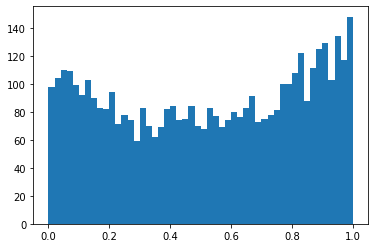

In [8]:
Y_test['scores'] = test_scores
n, bins, patches = plt.hist(Y_test[Y_test['CurvaCola']==1]['scores'], bins=50)
plt.show()

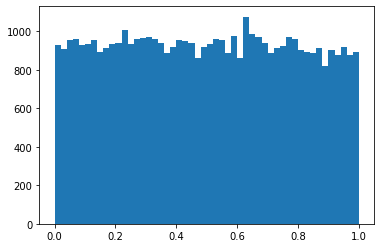

In [9]:
plt.hist(Y_test[Y_test['CurvaCola']==0]['scores'], bins=50)
plt.show()

Miramos los bins:

In [10]:
bins[0:2]

array([0.00028429, 0.02027674])

Analizamos la curva roc en función del punto en que discriminemos anomalía de no anomalía:

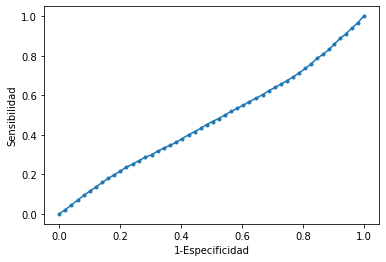

In [11]:
valores = np.array([])
sensibilidades = np.array([])
especificidades = np.array([])
for i in bins:
    Y_test['Y_pred'] = Y_test['scores'].map(lambda x: 1 if x < i else 0)
    valores = np.append(valores,i)
    sensibilidades = np.append(sensibilidades,recall_score(Y_test['CurvaCola'],Y_test['Y_pred']))
    especificidades = np.append(especificidades,recall_score(Y_test['CurvaCola'],Y_test['Y_pred'], pos_label=0))

plt.plot(1 - especificidades, sensibilidades,'.-')
plt.ylabel('Sensibilidad')
plt.xlabel('1-Especificidad')
plt.show()

In [16]:
Y_test['Y_pred'] = Y_test['scores'].map(lambda x: 1 if x < bins[10] else 0)

## Métricas

In [17]:
roc_auc = roc_auc_score(Y_test[anomalia], Y_test['Y_pred'])
accuracy = accuracy_score(Y_test[anomalia],Y_test['Y_pred'])
precision = precision_score(Y_test[anomalia],Y_test['Y_pred'])
kappa = cohen_kappa_score(Y_test[anomalia],Y_test['Y_pred'])
sensibilidad = recall_score(Y_test[anomalia],Y_test['Y_pred'])
especificidad = recall_score(Y_test[anomalia],Y_test['Y_pred'], pos_label=0)

valores = [roc_auc,accuracy,precision,kappa,sensibilidad,especificidad]
metricas = pd.DataFrame(valores)
metricas.index = metricas_list
metricas.columns = [anomalia]

Analizo las métricas:

In [18]:
metricas.T

,roc_auc,accuracy,precision,kappa,sensibilidad,especificidad
CurvaCola,0.507783,0.748221,0.094266,0.009833,0.215939,0.799626


In [19]:
Y_test.to_csv('Resultados/IForestASD_completo.csv')